# Modeling Shark Attack Occurrence: A Supervised Learning Approach

**Introduction/Background**

Shark attacks are extremely rare events with great consequences for the victims involved. These events have become widely popularized in modern culture and media because of their violent and novel nature. That said, public exposure to these events widely inflated relative to their actual occurrence. Individual risk, as reported by the ISAF is 1 in 11.5 million, but this can vary based on the profile of the individual (e.g. individual’s number of visits to the beach, activity while in the water, etc.). 

With this in mind, shark attacks are still events that occur with risk that can be modeled. And where risk can be modeled, individuals can assess and make judgements for themselves on how to navigate through the world. This paper will explore various factors associated with shark attack occurrences, and will attempt to quantify the risk involved so that individuals can make judgements for themselves on how to interpret that risk. 

The main sources of data for these events is The International Shark Attack File (ISAF). The ISAF is a catalog of all these events and is a widely trusted database on shark attack occurrences globally, curated by researchers at the University of Florida (special acknowledgement and thanks to Dr. Gavin Naylor and Joseph Miguez for this data). To help decrease model complexity and to provide a manageable project scope, only a subset of this data was pulled: specifically, unprovoked attack occurrences on the Atlantic Coast of Florida. The possibility of heterogeneity in pulling a specific dataset such as this, rather than global data is a limitation that will be discussed further in the conclusion of this paper. 

Data Citations: 

Florida Museum. (n.d.). International Shark Attack File. Florida Museum of Natural History. Retrieved September 25, 2025, from https://www.floridamuseum.ufl.edu/shark-attacks/

University of West Florida, Haas Center. (n.d.). Tourism indicators. University of West Florida. Retrieved September 25, 2025, from https://uwf.edu/centers/haas-center/explore-the-economy/tourism-indicators/

**Problem Statement**

The main problem that is being solved by this project is: Given temporal and weather data, can a shark attack occurrence be reliably predicted? This is not to say that the aim of this project is to model individual risk of attack, rather the general occurrence of an attack given the features at hand. This is an important distinction that is necessary to understand when viewing the data and results. 

**Hypothesis**

The two general questions tested in this project are:

1.	Can temporal features (i.e. time of day, month of year, and lunar phases) help provide indication of a shark attack occurrence?
2.	Can weather features (i.e. barometric pressure, temperature, and the change of these features over time) provide indication of shark attack occurrence?

Regarding temporal features, it is widely known shark attacks occur more often on a seasonal basis. These events happen more often in warmer months due to more beachgoers and shark migratory patterns. Additionally, it is known that more attacks occur during day hours due to the fact that more people visit the beach during the day rather than night. Furthermore, it is also thought that the lunar phases have an effect on shark attack occurrence, due to general lunar illumination. These features and their effect on shark attack occurrence will be tested via the models later mentioned. 

Regarding weather features, the interaction that is of interest for this project is barometric pressure, temperature, and the delta and rate of change between these variables over time. As all aquatic life are sensitive to dramatic shifts in their environment, these models will test whether or not these shifts influence shark behavior in a way that has an effect on shark attack occurrence. The causal nature of this affect is not being measured (i.e. whether sharks become more aggressive or whether they flee an area when there are dramatic shifts in these features), rather the overall correlation between these whether events and shark attack occurrences themselves.

# Part 1: Data Import and Cleansing 

**In terms of size, the data is 95 columns wide and has 736 rows, some of which have incomplete data.**

First importing all the necesary libraries

In [1]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import statsmodels.formula.api as smf
import statsmodels.api as sm
import re
import math
from datetime import datetime

#import ephem

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline



Installing openyxl as the CSV reader was giving me trouble

In [2]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.3/251.3 kB 32.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


One of the main challenges in this project was data sanitization. The ISAF is a near-century old project, with data going back from the 1500s- present. Data drift is an inevitable threat with a project as long-standing as this, and sanitization is a normal part of the modeling process. Why and how values are inputted have changed over time, and the data reflects this. Multiple cleansing and parsing functions were used to create a sanitized output.

The first of these were functions created to parse through the ‘time-of-attack’ feature, which is one of the most critical to this analysis. As the data varied between written phrases such as “Forenoon” and “Afternoon”, the usage of AM/PM, military time, and general ranges such as “2:00- 4:00”, a variety of functions were created to parse this information. Additionally, functions were created to “bucket-ize” this time of attack feature and create new features based off of this. This includes the creation of a general time-of-day feature that shows whether the attack occurred in morning, afternoon, evening, or night, which was useful for visualizations. 

Additional features were also created from the ‘date_at_location’ feature to help create more modeling value. The first of these was the creation of general months, and seasons, based on the date. The second was the creation of features related to the lunar phases. Three functions were created to calculate the general lunar phase (new, first quarter, full, last quarter), the general lunar illumination fraction (expressed as a fraction for modeling purposes), and general lunar illumination percentage (expressed as a percentage for visualization purposes).

Another thing to note is that unnecessary columns were dropped (such as body parts involved in the attack) to reduce noise while modeling and to curtail the dataframe. Additionally, all provoked attacks were dropped from the data, as the scope of this project pertains to solely unprovoked instances. As provoked instances vary widely, the risk is that they would have skewed the results of the analysis. 

One of the byproducts of this project is a cleaned output of data, as well as a data cleansing pipeline that can both be used for further projects such as this. 

**In terms of size, the data is 95 columns wide and has 736 rows, some of which have incomplete data.**

Reading in the data below

In [3]:
df = pd.read_excel('data/Atlantic_Coast_Florida_Metadata.xlsx', engine='openpyxl')
df_2 = pd.read_excel('data/Air_Traffic_data.xlsx', engine='openpyxl')

Inspecting the data to see features available and data quality

In [4]:
df.head()

,authenticity,attack_classification,outcome,continent,country,state,county,0-all attacks.locality,date_at_location,Year,...,bone_exposed,body_cavity_exposed,appendage_loss_to_shark,appendage_loss_to_surgery,trunk_severed,swallowed_whole,skeletonized,wounds_other_than_above,provocative_acts,activity_addenda
0,"Confirmed, shark involvement also confirmed",Unprovoked attack,Non-fatal,North America,USA,Florida,Palm Beach County,NaN,1931-09-21,1931,...,No,Data insufficient for judgement,No,No,No,No,No,Data insufficient for judgement,None known/unprovoked attack,NaN
1,"Confirmed, shark involvement also confirmed",Unprovoked attack,"Fatal Attack, body or parts thereof recovered,...",North America,USA,Florida,Brevard County,"Indiatlantic Beach, just across the bridge for...",1934-06-20,1934,...,Data insufficient for judgement,No,No,No,No,No,No,Data insufficient for judgement,None known/unprovoked attack,NaN
2,"Confirmed, shark involvement also confirmed",Unprovoked attack,Non-fatal,North America,USA,Florida,Duval County,Mayport,1944-05-31,1944,...,Data insufficient for judgement,No,No,No,No,No,No,No,None known/unprovoked attack,NaN
3,"Confirmed, shark involvement also confirmed",Unprovoked attack,Non-fatal,North America,USA,Florida,St. Johns County,"Crescent Beach, in front of Sea Haven Condos",1952-06-02,1952,...,No,No,No,No,No,No,No,Data insufficient for judgement,None known/unprovoked attack,NaN
4,"Confirmed, shark involvement also confirmed",Unprovoked attack,Non-fatal,North America,USA,Florida,St. Lucie County,"Fort Pierce, South Beach",1957-02-05,1957,...,Data insufficient for judgement,No,No,No,No,No,No,No,None known/unprovoked attack,"Floating on back, no flotation device reported"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 95 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   authenticity                   736 non-null    object        
 1   attack_classification          736 non-null    object        
 2   outcome                        736 non-null    object        
 3   continent                      736 non-null    object        
 4   country                        736 non-null    object        
 5   state                          736 non-null    object        
 6   county                         736 non-null    object        
 7   0-all attacks.locality         728 non-null    object        
 8   date_at_location               736 non-null    datetime64[ns]
 9   Year                           736 non-null    int64         
 10  victim_activity                736 non-null    object        
 11  abdomen_stomach    

After doing an inspection of the data, it looks like there are a lot of features that I dont necesarily need for this project. All the data regarding the type of bite, body parts affected, and other miscelaneous information I removed so as to not confound any further analysis I do.

**In terms of size, the data is 95 columns wide and has 736 rows, some of which have incomplete data.**

In [6]:
df_clean = df[['attack_classification', 'outcome', 'county', 'date_at_location', 'Year', 
              'time_of_attack','victim_activity', 'sunlight_conditions', 'gen_weather', 'air_temp', 'water_temp', 
              'closest_phase', 'waxing_waning', 'common_name', 'provocative_acts', 'activity_addenda']].copy()


print(df_clean['time_of_attack'].unique())
print(df_clean['outcome'].unique())
print(df_clean['attack_classification'].unique())

['Data insufficient for judgement' '09:00'
 'data insufficient for judgement' '10:30' '1530' '11:00' '1700' '15:30'
 '15:00' '12:00' '11:30' 'late afternoon/evening' '1330' '14:30' '13:30'
 '07:00' '1500' '16:00' '16:30' 'afternoon' '14:00' '16:56' '08:55'
 '16:40' '13:50' '10:00' '16:06' '13:00' '11:15' 'morning' '13:15' '17:30'
 '14:45' '14:15' '19:30' '18:00' '09:45' '08:00' '12:30' 'forenoon'
 '17:00' '14:10' '09:15' '19:00' 'night' '18:45' '11:45' '18:30' '12:15'
 '18:20' '16:50' '11:50' '08:30' '16:35' '04:00' '10:55' '17:45' '07:45'
 '18:12' '14:25' '19:35' '09:25' '14:54' '09:10' '13:20' '14:20' '08:45'
 '19:07' '15:50' '07:30' '18:15' '11:06' '13:25' '18:05' '13:45' '11:20'
 '11:36' '10:25' '09:30' '13:43' '17:15' '18:02' '09:35' '11:10' '17:59'
 '20:15' '15:45' '18:40' 'Afternoon' '11:57' '14:55' '17:02' '14:50'
 '17:42' '12:48' '11:00-14:00' '12:46' '10:50' '13:06' '13:14' '16:15'
 '16:20' '14:40' '10:15' '06:45' '10:40' '14:47' '12:05' '15:55' '13:40'
 '19:15' '12:20' '13:2

As you can see below, I am cleansing the "Outcome" feature below. I am creating a binary and ternary feature that describes whether the outcome was fatal or non-fatal based on the text entered in this column. This will be useful if I deide to do logistic modeling on the Outcome

Also, I am deleting all rows where the attack classification is a provoked attack. This culls 64 rows from the overall dataset, but this is a necesary action due to the fact that provoked attacks could happen for too many numerous factors. This will protect our data integrity

In [7]:
#Data Cleansing

df_clean = df_clean[df_clean['attack_classification'] != 'Provoked attack'].copy()

#deleting all rows that are provoked attacks

df_clean['outcome'] = df_clean['outcome'].replace({
'Non-fatal': 'non-fatal',
 'Fatal Attack, body or parts thereof recovered, death considered direct result of shark-inflicted wounds': 'fatal',
 'Assumed fatal attack, body not recovered, no personal gear recovered': 'assumed_fatal',
 'Assumed fatal attack, body not recovered, personal gear recovered': 'assumed_fatal',
 'Fatal, body or parts thereof recovered, not known whether death was a direct result of shark-inflicted wounds':'fatal'
})

for col in ['attack_classification', 'outcome','county', 'victim_activity', 'sunlight_conditions', 'gen_weather', 
           'closest_phase', 'waxing_waning', 'common_name', 'provocative_acts', 'activity_addenda']:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()
    


df_clean['outcome_binary'] = df_clean['outcome'].map({'fatal': 1, 'assumed_fatal': 1, 'non-fatal': 0})

df_clean['outcome_ternary'] = df_clean['outcome'].map({'fatal': 1, 'assumed_fatal': 2, 'non-fatal': 0})



In [8]:
print(df_clean['outcome'].unique())

['non-fatal' 'fatal' 'assumed_fatal']


Now, I am getting into the temporal data cleansing below. I created a few fucntions that go through the time_of_attack feature and normalize it so it is consistent throughout. I really would like this feature to be used in modelling so I am spending a lot of time and effort cleaning it. 

Additionally I am creating a function that bucketizes the data into general day phases (i.e. dawn, day, dusk, night)

In [9]:
#time_of_attack needs some heavy data cleansing here

def midpoint(h1, h2):
    if h1 is None or h2 is None:
        return None
    return (h1 + ((h2-h1)% 24)/2) % 24

def ampmparse(s: str):
    for fmt in ("%I%p", "%I %p", "%I:%M%p", "%I:%M %p"):
        try: 
            t = datetime.strptime(s.strip().upper(), fmt)
            return t.hour + t.minute/60.0
        except ValueError:
            continue
    return None

def hhmmparse(hhmm: str):
    try:
        hh, mm = hhmm.split(":")
        hh, mm = int(hh), int(mm)
        if 0 <=hh <= 23 and 0 <= mm <= 59:
            return hh + mm/60.0
    except Exception:
        pass
    return None

def normalize_time(val):
    if val is None or (isinstance(val, float)and math.isnan(val)): 
        return np.nan
    s = str(val).strip()
    
    sl = s.lower()
    if sl == "data insufficient for judgement":
        return np.nan
    
    s = s.replace(",", ":")
    
    #for the single instance of midpoint range 11:00 - 14:00
    if "-" in s: 
        try:
            left, right = s.split("-")
            h1, h2 = hhmmparse(left.strip()), hhmmparse(right.strip())
            return midpoint(h1, h2)
        except Exception:
            return np.nan
            
    #ampm normalization
    ampm_val = ampmparse(s)
    if ampm_val is not None:
        return ampm_val
    
    #military time normalization
    if re.fullmatch(r"\d{3,4}", s): 
        hh, mm = int(s[:-2]), int(s[-2:])
        if 0<= hh <= 23 and 0<= mm <= 59:
            return hh + mm/60.0
    
    # HH:MM and H:MM
    if re.fullmatch(r"\d{1,2}:\d{2}", s):
        return hhmmparse(s) 
        
    
    # HH
    if re.fullmatch(r"\d{1,2}", s):    
        hh = int(s)
        if 0<= hh <= 23:
            return float(hh)
    
    #General phrases
    phrase_map = {"forenoon": 10.0, "morning": 9.0, "afternoon": 15.0, "late afternoon/evening" : 18.0, "night": 22.0}
    if sl in phrase_map:
        return phrase_map[sl]
    
    return np.nan

def time_buck(h):
    
    if pd.isna(h):
        return "unknown"
    if 5 <= h < 9:
        return "dawn"
    if 9 <= h < 17:
        return "day"
    if 17<= h < 21:
        return "dusk"
    return "night"


Creating my new time of attack features from the functions above

In [10]:
#data cleansing contd. 

df_clean["time_of_attack_hour"] = df_clean["time_of_attack"].apply(normalize_time)

df_clean["time_unknown_flag"] = df_clean["time_of_attack_hour"].isna().astype(int)

df_clean["time_bucket"] = df_clean["time_of_attack_hour"].apply(time_buck)



Now, just printing all the unique values to make sure that this worked correctly and to get an idea of what I am working with

In [11]:
print(df_clean['time_of_attack_hour'].unique())
print(df_clean['time_bucket'].unique())
print(df_clean['time_unknown_flag'].unique())

[        nan  9.         10.5        15.5        11.         17.
 15.         12.         11.5        18.         14.5        13.5
  7.         16.         16.5        14.         16.93333333  8.91666667
 16.66666667 13.83333333 10.         16.1        13.         11.25
 13.25       17.5        14.75       19.5         9.75        8.
 12.5        14.16666667 19.         22.         18.75       11.75
 18.5        12.25       14.25       18.33333333 16.83333333 11.83333333
  8.5        16.58333333  4.         10.91666667 17.75        7.75
 18.2        14.41666667  9.41666667 14.9         9.16666667 13.33333333
 14.33333333  8.75       19.11666667 15.83333333  7.5        18.25
 11.1        13.41666667 18.08333333 13.75       11.33333333 11.6
 10.41666667  9.5        13.71666667 17.25       18.03333333  9.58333333
 11.16666667 17.98333333 20.25       15.75       18.66666667 14.91666667
 17.03333333 14.83333333 17.7        12.8        12.76666667 10.83333333
 13.1        13.23333333 16.25  

Now, I want to work on celaning the date at location feature, deriving the month and general season from that data as well, so I can test my hypothesis on seasonality.

There is some odd air_temp data that seems to be in Farenheight, so I am masking that here as well. This may not be used, but I will cleanse anyways.





In [12]:
df_clean['date_at_location'] = pd.to_datetime(df_clean['date_at_location'], errors = 'coerce')
df_clean['month'] = df_clean['date_at_location'].dt.month
df_clean['season'] = df_clean['month'].map({
 12: 'winter', 1: 'winter', 2: 'winter',
 3: 'spring', 4: 'spring', 5: 'spring',
 6: 'summer', 7:'summer', 8:'summer',
 9:'fall', 10: 'fall', 11: 'fall'})

for col in ['air_temp', 'water_temp']:
    df_clean[col] = pd.to_numeric(df_clean[col], errors = 'coerce')
    
faren_mask = df_clean['air_temp'] > 60
df_clean.loc[faren_mask, 'air_temp'] = (df_clean.loc[faren_mask, 'air_temp'] - 32) *(5/9)

hr = df_clean['time_of_attack_hour']


df_clean['hour_sin'] = np.sin(2*np.pi*hr/24)
df_clean['hour_cos'] = np.cos(2*np.pi*hr/24)

In the cell below I create functions that derive the moon phase and lunar illumination from the date. This should be more reliable than the given lunar features in the data, and will help me test my hypothesis on lunar phase impacting the occurence of shark attacks

As you can see above, I end up with 4 new features- 

lunar_phase: which bucketizes all the occurences into 4  equal bins (new, last_quarter, first_quarter, and full)

lunar_illumination_phase: the 0-1 value of lunar phase

lunar_illumination_frac: 0-1 value that indicates the lunar illumination (0-1 easier for modleing)

lunar_illumination_pct:  0-100 percentage value that indicates the lunar illumination (0-100 easier for visualization)


In [13]:
def moon_phase(date):
    if pd.isna(date):
        return None
    last_known_new_moon = pd.Timestamp("2000-01-06")
    syn_month = 29.5305887
    days = (pd.to_datetime(date)- last_known_new_moon).days
    return (days % syn_month)/ syn_month

df_clean["lunar_illumination_phase"]= df_clean["date_at_location"].apply(moon_phase)


def illuminationfrac(phase):
    if phase is None:
        return None
    return 0.5* (1-np.cos(2*np.pi*phase))

df_clean["lunar_illumination_frac"] = df_clean["lunar_illumination_phase"].apply(illuminationfrac)
df_clean["lunar_illumination_pct"] = df_clean["lunar_illumination_frac"]*100.0



def moon_phase_norm(val):
    if val is None:
        return "unknown"
    if val <0.125 or val >= 0.875:
        return  "new"
    elif val <0.375:
        return "first_quarter"
    elif val<0.625:
        return "full"
    else:
        return "last_quarter"
    
df_clean["lunar_phase"]= df_clean["lunar_illumination_phase"].apply(moon_phase_norm)

print(df_clean['lunar_phase'].value_counts(dropna = False))
print(df_clean['lunar_illumination_pct'].value_counts(dropna = False))
print(df_clean['lunar_illumination_frac'].value_counts(dropna = False))
print(df_clean['lunar_illumination_phase'].value_counts(dropna = False))

new              183
full             166
last_quarter     163
first_quarter    159
Name: lunar_phase, dtype: int64
95.828611    4
0.170482     4
12.160051    4
1.573899     4
0.422984     3
            ..
99.692238    1
72.243376    1
97.194988    1
11.465200    1
74.325882    1
Name: lunar_illumination_pct, Length: 599, dtype: int64
0.121601    4
0.015739    4
0.958286    4
0.001705    4
0.004230    3
           ..
0.920522    1
0.058864    1
0.500471    1
0.011702    1
0.408360    1
Name: lunar_illumination_frac, Length: 600, dtype: int64
0.040039    4
0.565472    4
0.979283    3
0.013147    3
0.113381    2
           ..
0.280508    1
0.749577    1
0.756782    1
0.999479    1
0.264208    1
Name: lunar_illumination_phase, Length: 604, dtype: int64


Now, I think I am cleansing done for now, so I would like to test and visualize some of the counts and values of the data in the below cells

In [14]:
print(df_clean['month'].unique())
#print(df_clean['date_at_location'].unique())
print(df_clean['air_temp'].unique())
print(df_clean['water_temp'].unique())


               

[ 9  6  5  2  4  3  7  8  1 10 11 12]
[        nan 24.         26.         29.         28.         30.
 18.         27.         31.         21.         32.         33.
 20.         23.         22.         26.7        28.5        31.1
 25.6        35.         23.8        16.         29.4        32.22
 37.         28.8        25.5        32.2        27.7        33.3
 30.3        36.         28.9        30.5        25.         22.22
 23.89       27.2        19.         24.44       22.77       26.667
 28.3        21.7        31.66666667 31.7        30.6        27.8
 21.4        34.4        33.8        26.1        26.6        32.78
 22.7        29.44       23.9        31.11      ]
[   nan 20.    25.    22.    26.    21.    24.    28.    18.    23.
 29.    27.    17.    31.    32.    30.    33.    19.4   19.    25.6
 29.4   21.6   25.5   26.5   15.6   26.7   23.9   24.44  24.4   20.5
 23.8   22.2   27.8   27.6   21.1   20.6   27.2   26.1   25.56  26.67
 23.3   28.3   21.67  22.7   23.88  27.

In [15]:
print(df_clean['outcome'].value_counts(dropna = False))
print(df_clean[['outcome', 'outcome_binary', 'outcome_ternary']].head(10))
print(df_clean['time_bucket'].value_counts(dropna = False))
df_clean[['air_temp', 'water_temp']].describe()

non-fatal        662
fatal              6
assumed_fatal      3
Name: outcome, dtype: int64
      outcome  outcome_binary  outcome_ternary
0   non-fatal               0                0
1       fatal               1                1
2   non-fatal               0                0
3   non-fatal               0                0
4   non-fatal               0                0
5   non-fatal               0                0
8   non-fatal               0                0
9   non-fatal               0                0
10  non-fatal               0                0
12  non-fatal               0                0
day        444
unknown     97
dusk        95
dawn        33
night        2
Name: time_bucket, dtype: int64


,air_temp,water_temp
count,214.000000,373.000000
mean,28.201139,25.713812
std,3.888885,3.163131
min,16.000000,15.600000
25%,26.000000,24.000000
50%,29.000000,26.000000
75%,31.000000,28.000000
max,37.000000,33.000000


Printing out info and data head below of my newly cleansed data. A couple things that stick out to me is that the hourly time of attack features, as well as the temperature features have a lot of null values. I may have to either ommit those rows, or fill the data synthetically at a later point

In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671 entries, 0 to 735
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   attack_classification     671 non-null    object        
 1   outcome                   671 non-null    object        
 2   county                    671 non-null    object        
 3   date_at_location          671 non-null    datetime64[ns]
 4   Year                      671 non-null    int64         
 5   time_of_attack            668 non-null    object        
 6   victim_activity           671 non-null    object        
 7   sunlight_conditions       671 non-null    object        
 8   gen_weather               671 non-null    object        
 9   air_temp                  214 non-null    float64       
 10  water_temp                373 non-null    float64       
 11  closest_phase             671 non-null    object        
 12  waxing_waning         

In [17]:
df_clean.head()

,attack_classification,outcome,county,date_at_location,Year,time_of_attack,victim_activity,sunlight_conditions,gen_weather,air_temp,...,time_unknown_flag,time_bucket,month,season,hour_sin,hour_cos,lunar_illumination_phase,lunar_illumination_frac,lunar_illumination_pct,lunar_phase
0,unprovoked attack,non-fatal,palm beach county,1931-09-21,1931,Data insufficient for judgement,swimming,daylight,clear,NaN,...,1,unknown,9,fall,NaN,NaN,0.316535,0.702989,70.298907,first_quarter
1,unprovoked attack,fatal,brevard county,1934-06-20,1934,09:00,standing still on bottom,daylight,data insufficient for judgement,NaN,...,0,day,6,summer,0.707107,-0.707107,0.281316,0.597749,59.774941,first_quarter
2,unprovoked attack,non-fatal,duval county,1944-05-31,1944,data insufficient for judgement,data insufficient for judgement,data insufficient for judgement,data insufficient for judgement,NaN,...,1,unknown,5,spring,NaN,NaN,0.306293,0.673187,67.318656,first_quarter
3,unprovoked attack,non-fatal,st. johns county,1952-06-02,1952,10:30,standing still on bottom,daylight,data insufficient for judgement,NaN,...,0,day,6,summer,0.382683,-0.923880,0.322267,0.719313,71.931296,first_quarter
4,unprovoked attack,non-fatal,st. lucie county,1957-02-05,1957,1530,"floating, little or no motion (includes use of...",daylight,data insufficient for judgement,NaN,...,0,day,2,winter,-0.793353,-0.608761,0.194463,0.329044,32.904399,first_quarter


In [18]:
#df_clean.to_csv('df_clean_here', index = False)

# Part 2: EDA and Visualization on Temporal Data 

Exploratory data analysis and the creation of visuals is a key step for a project such as this, because it allows one the ability to see what key features they are going to use in modelling and how these features might affect the model. Many visualizations were created to make sense of the data. The visualizations shared below are the most relevant to the modelling that was subsequently done. 

**Temporal Visualizations**

The below visualizations related to count of shark attack occurrences across different measures of time are quite simple in and of themselves, but  they do show us a few different things to look out for in the subsequent modeling. The first is that, unsurprisingly, shark attacks for this dataset tend to skew towards daytime hours, specifically in the mid-day to afternoon. The second is that shark attacks for this dataset skew toward late summer, early fall months. The third is that shark attacks for this dataset may have a slight uptick around new moons. All this being said, these visualizations aren’t enough to determine whether these imbalances are simply indicative of the dataset itself, or can be used to infer future occurrences. In other words, are these results statistically significant? 


## Correlation Heatmap

Looking at the features below, there are a few that have some correlation between them. The highest are between some of our feature-engineered values (e.g. hour-sin, hour-cos, and hour), but we can ignore those correlations for now because the engineered features are dependent on what they have been created from. 

Some potentially interesting correlations below is water temp and month, as well as air temp and month. This makes sense intuitively as there is a correlation as the air temperature increases in times of the year. 

At the moment, this correlation heatmap wont be extremely usefull in identifying model features, due to the fact that synthetic negatives are not created yet. This will be run again after the synthetic negatives are added in. 

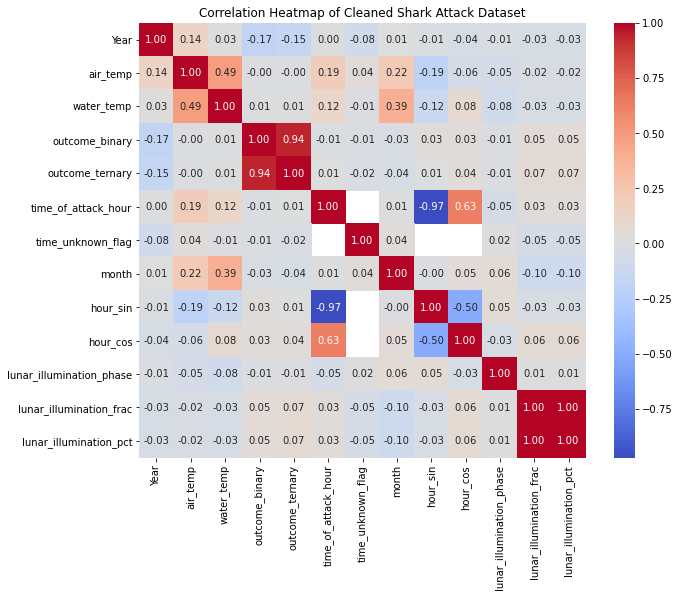

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.select_dtypes(include = ["number"]).corr(), 
            annot = True, cmap = "coolwarm", fmt = ".2f", cbar = True)

plt.title("Correlation Heatmap of Cleaned Shark Attack Dataset")
plt.show()

# Hourly Visualizations

The first thing I want to visualize is the shark attack occurences vs hour of day.

As you can see below, a majority of shark attacks happen towards the daylight hours. This doesnt mean that sharks arent willing to bite people at night-time thought. This more likely due to the fact that beachgoers attend the beach during daylight hours. 

0.10.1


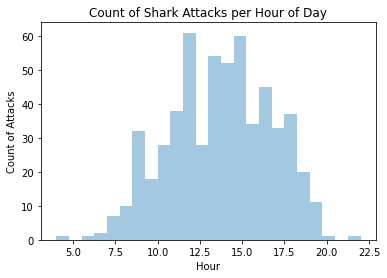

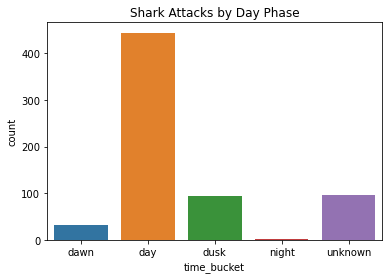

In [19]:
print(sns.__version__)

plt.figure()
sns.distplot(df_clean['time_of_attack_hour'], bins = 24, kde = False)
plt.xlabel("Hour")
plt.ylabel("Count of Attacks")
plt.title("Count of Shark Attacks per Hour of Day")
plt.show()

plt.figure()
sns.countplot(x = 'time_bucket', data = df_clean, order = ["dawn", "day", "dusk", "night", "unknown"])
plt.title("Shark Attacks by Day Phase")
plt.show()

# Monthly/Seasonal Visualizations

Again, visualizing some of the temporal data, but looking at it on a monthly/seasonal basis below. 

As you can see, we have a large amount of attacks skewed toward the summer and fall months (months 6-11). Again, this could likely be due to the fact that beachgoers are more likely to visit the beach in the summer and fall months, when temperatures in Florida are more mild, but I would like to inspect this further. 

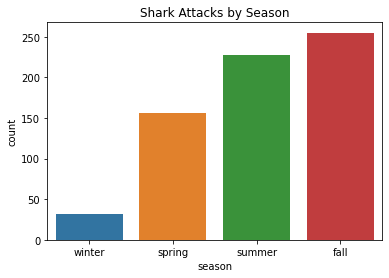

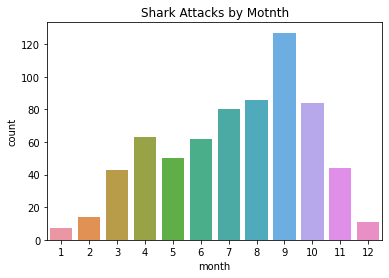

In [20]:
plt.figure()
sns.countplot(x = 'season', data = df_clean, order = ["winter", "spring", "summer", "fall"])
plt.title("Shark Attacks by Season")
plt.show()

plt.figure()
sns.countplot(x = 'month', data = df_clean,)
plt.title("Shark Attacks by Motnth")
plt.show()


# Lunar Phase/Illumination Visualizations

Now, I am looking at the interaction between shark attacks and lunar phase/illumnation percentage.

Looking below, you can first see the shark attack occurence plotted with the lunar illumination phase (mapped from 0-1, where 0 is a New moon, 0.5 is full, and 1 is a new moon again). This looks to show a slight skew toward the new moon, but this visualization is not great due to how the feature is set up. The feature is more useful for modleing than visualiing.

As you can see in the seccond graphic, I mapped the count of attacks by the lunar illumination percentage. This chart is interesting, but it can be decieving, because it looks as though we have a very large skew toward new moons and full moons. While this seems to be the case, the reality is that if you were to also chart the lunar illumination by time, you would see a simmilar breakdown.

So, all that to say, I believe the final visual to be most telling. It shows the shark attack occurences by buketized versions of the lunar phases (first quarter, full, last quarter, and new moon). As you can see in the data, there seems to be a slight skew toward the new moon, but we cannot tell from this visualization alone whether that skew is significant or not. That is what our modeling will be for

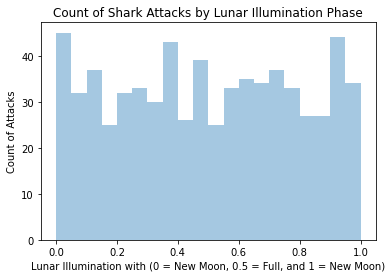

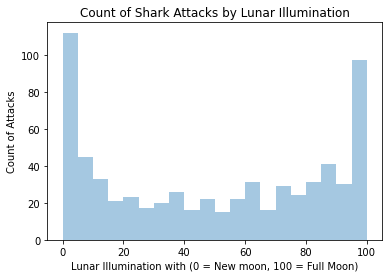

Text(0.5, 1.0, 'shark Attacks By Lunar Phase')

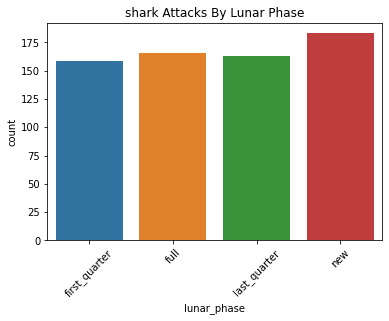

In [21]:

plt.figure()
sns.distplot(df_clean['lunar_illumination_phase'].dropna(), bins = 20, kde = False )
plt.xlabel("Lunar Illumination with (0 = New Moon, 0.5 = Full, and 1 = New Moon)")
plt.ylabel("Count of Attacks")
plt.title("Count of Shark Attacks by Lunar Illumination Phase")
plt.show()


plt.figure()
sns.distplot(df_clean['lunar_illumination_pct'].dropna(), bins = 20, kde = False)
plt.xlabel("Lunar Illumination with (0 = New moon, 100 = Full Moon)")
plt.ylabel("Count of Attacks")
plt.title("Count of Shark Attacks by Lunar Illumination")
plt.show()

# plt.figure()
# sns.countplot(x = 'closest_phase', data = df_clean, order= sorted(df_clean['closest_phase'].dropna().unique()))
# plt.xticks(rotation = 45)
# plt.title("shark Attacks By Lunar Phase")


plt.figure()
sns.countplot(x = 'lunar_phase', data = df_clean, order= sorted(df_clean['lunar_phase'].dropna().unique()))
plt.xticks(rotation = 45)
plt.title("shark Attacks By Lunar Phase")


# Bonus Visualizations: Count of Attacks over time and shark attacks vs temperature

I created a few extra visualizations to see some other interactions that might be intersting to note. 

As you can see, the count of shark attacks over time has been increasing. This is a well-known phenomenon and largely attributed to the fact that our global population has grown. More people = more bites. If we were to map this data to the population of Florida, I am sure we would find a similar trend. 

Additionally, we have a count of water temperature variance and shark attack occurence. This is an interesting thing to note and something we may come back to later. A skew toward a smaller range of termperatures, but this may just because the majority of Florida seasons involve these temperatures

Text(0.5, 1.0, 'Shark Attacks Since 1931')

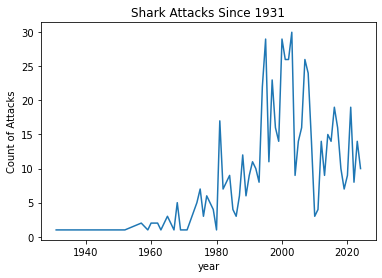

In [22]:
plt.figure()
df_clean.groupby('Year').size().plot()
plt.xlabel("year")
plt.ylabel("Count of Attacks")
plt.title("Shark Attacks Since 1931")


<function matplotlib.pyplot.show(*args, **kw)>

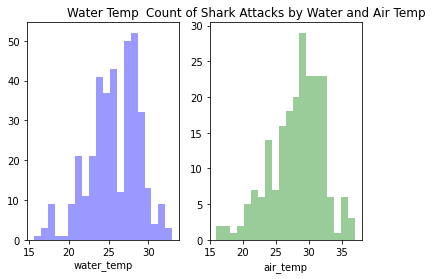

In [23]:
fig = plt.figure()
axes = fig.subplots(1,2)
sns.distplot(df_clean['water_temp'].dropna(), bins = 20, ax = axes[0], color = "blue", kde = False)
axes[0].set_title("Water Temp")
sns.distplot(df_clean['air_temp'].dropna(), bins = 20, ax = axes[1], color = "green", kde = False)
axes[1].set_title("Air Temp")
plt.title("Count of Shark Attacks by Water and Air Temp")
plt.show

#Maybe try overlaying month data below air and month temp

In [24]:
print(df_clean[['time_bucket', 'time_of_attack_hour', 'month', 'lunar_illumination_frac']].isna().sum())

time_bucket                 0
time_of_attack_hour        97
month                       0
lunar_illumination_frac     0
dtype: int64


# Part 3: Modeling Temporal Data Mapped to Shark Attack Occurences via Logistic Regression

**Modeling Approach**

**Logistic Regression**

When approaching how to model this problem, the nature of the what is being modeled was assessed. In this case, the outcome that was to be predicted was binary, whether a shark attack occurred or not based on the predictor at hand. In this case, logistic regression is a clear choice, as the predicted class in this method of supervised learning is a binary case.
 
**Accounting for Non-Shark Attack Occurrences (Negative Events)**

After selecting logistic regression as the method of supervised learning to solve this problem, one main issue arose, which is the absence of negative cases. The data involved in this project is confirmed shark attack occurrences, and we do not have confirmed non-occurrences. This seems a silly distinction to make, as this is an obvious thought. There would be no point in recording non-shark attack occurrences, because they happen every day all around the world. The reason it is important is that the model will have to somehow account for these negative events. 

To do so, the solution implemented in this particular project was the creation of synthetic negatives. Synthetic negatives allow one to account for all the non-shark attack occurrences. A reasonable question to ask would be: Wouldn’t the synthetic negatives just represent the entire date-length of the dataset where attacks didn’t occur (e.g. in this case, that would be every non-shark attack month, day, hour since 1931)? Unfortunately, one cannot feed a model this number of negative events, as shark attacks are such rare occurrences, the amount of non-attack occurrences are so large it greatly outweighs the attack occurrences.  In this case, an equal length of data is sufficient to remove the model bias that would be had if one were to overwhelm it with negative events.  


In [39]:
df_pos = df_clean[['date_at_location', 'time_of_attack_hour']].copy()
df_pos = df_pos[df_pos['time_of_attack_hour']>= 0]
df_pos['attack_binary'] = 1

df_pos['month'] = df_pos['date_at_location'].dt.month


# df_pos['lunar_illumination_frac'] = df_pos['date_at_location'].apply(moon_phase)
# df_pos['lunar_phase'] = df_pos['date_at_location'].apply(moon_phase_norm)

df_pos['lunar_illumination_phase']= df_pos['date_at_location'].apply(moon_phase)
df_pos['lunar_illumination_frac'] = df_pos['lunar_illumination_phase'].apply(illuminationfrac)
df_pos['lunar_phase']= df_pos['lunar_illumination_phase'].apply(moon_phase_norm)


neg_date_range = pd.date_range(df_clean['date_at_location'].min(), df_clean['date_at_location'].max(), freq = 'D')
neg_dates = np.random.choice(neg_date_range, len(df_pos), replace = True)

neg_hours = np.random.randint(0,24, size = len(df_pos))


df_neg = pd.DataFrame({'date_at_location': neg_dates, 
                       'time_of_attack_hour': neg_hours,
                      'attack_binary': 0 })

df_neg['month'] = df_neg['date_at_location'].dt.month

# df_neg['lunar_illumination_frac'] = df_neg['date_at_location'].apply(moon_phase)
# df_neg['lunar_phase'] = df_neg['lunar_illumination_frac'].apply(moon_phase_norm)


df_neg['lunar_illumination_phase']= df_neg['date_at_location'].apply(moon_phase)
df_neg['lunar_illumination_frac'] = df_neg['lunar_illumination_phase'].apply(illuminationfrac)
df_neg['lunar_phase']= df_neg['lunar_illumination_phase'].apply(moon_phase_norm)



df_model = pd.concat([df_pos, df_neg], ignore_index = True)

print(df_model.groupby('attack_binary').size())

attack_binary
0    574
1    574
dtype: int64


## Correlation Heatmap for DF_Model

Now it looks like we have some significant results from our correlation heatmap with the synthetic negatives added in. There seems to be a correlation between attack binary (shark attack or not) and month, as well as hour. It should be noted that this is a point-biserial correlation (correlation between linear and binary values), so the correlation may not look as high as it actually is. The models below will prove out whether these are strong indicators or not

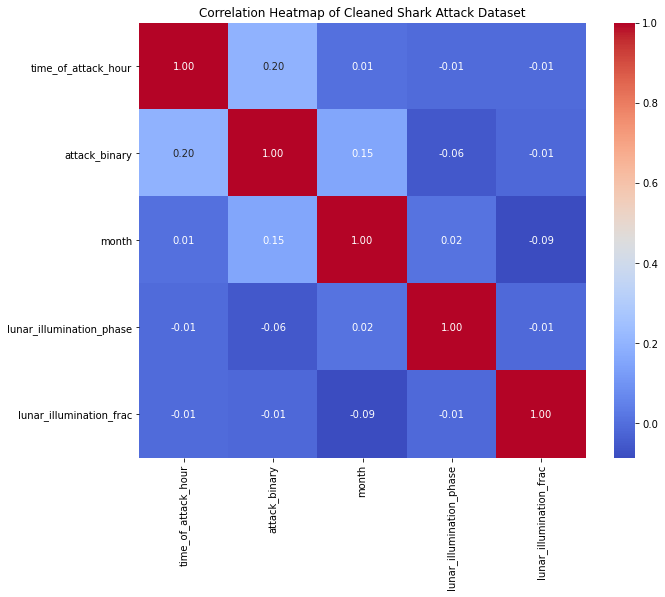

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_model.select_dtypes(include = ["number"]).corr(), 
            annot = True, cmap = "coolwarm", fmt = ".2f", cbar = True)

plt.title("Correlation Heatmap of Model Datafame Shark Attack Data")
plt.show()

# Lunar Illumination Logistic Regression

As you can see, the results of our logistic regression below for lunar illumination on the attack ocurrence were not strong. I would not say this is a strong predictor of attack occurence

              precision    recall  f1-score   support

           0       0.54      0.51      0.52       144
           1       0.53      0.55      0.54       143

    accuracy                           0.53       287
   macro avg       0.53      0.53      0.53       287
weighted avg       0.53      0.53      0.53       287

ROC_AUC: 0.5087412587412588
Intercept is  [-0.00738919]
Coefficient is  [[0.01505197]]


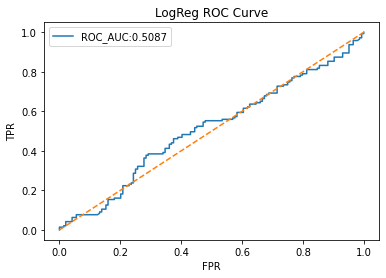

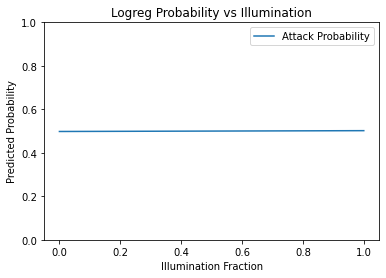

In [74]:
X = df_model[['lunar_illumination_frac']]
y = df_model['attack_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_prob))

print("Intercept is ", model.intercept_)
print("Coefficient is ", model.coef_)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label = f"ROC_AUC:{roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], linestyle = "--")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogReg ROC Curve')
plt.legend()
plt.show()

range_ = np.linspace(0,1,100).reshape(-1,1)
prob = model.predict_proba(range_)[:,1]
plt.xlabel('Illumination Fraction')
plt.ylabel('Predicted Probability')
plt.title('Logreg Probability vs Illumination')
plt.ylim(0,1)
plt.plot(range_, prob, label = 'Attack Probability')
plt.legend()
plt.show()

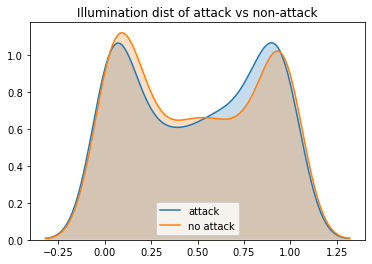

In [75]:
attack = df_model['attack_binary'] == 1
noattack = df_model['attack_binary'] == 0


sns.kdeplot(data = df_model.loc[attack, 'lunar_illumination_frac'], shade = True, label = 'attack')
sns.kdeplot(data = df_model.loc[noattack, 'lunar_illumination_frac'], shade = True, label = 'no attack')
plt.title("Illumination dist of attack vs non-attack")
plt.legend()
plt.show()

# Month Logistic Regression

Now looking at the monthly logistic regression model, this is a better indicator than lunar illumination. Looking at the predicted probabilities graph below, one can see that there is a higher predicted probability in the summer/fall months 6-10. You also can see that I had to use sin and cos encoding due to the cylical nature of monthly data

              precision    recall  f1-score   support

           0       0.68      0.56      0.61       144
           1       0.62      0.73      0.67       143

    accuracy                           0.64       287
   macro avg       0.65      0.64      0.64       287
weighted avg       0.65      0.64      0.64       287

ROC_AUC: 0.6947843822843823
Intercept is  [-0.14032613]
Coefficient is  [[-0.59029376 -0.50607677]]


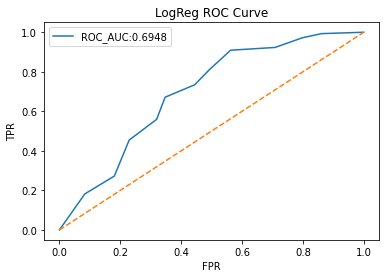

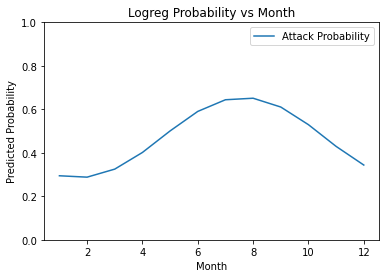

In [76]:
df_model['month_sin'] = np.sin(2*np.pi*df_model['month']/12)
df_model['month_cos'] = np.cos(2*np.pi*df_model['month']/12)

X = df_model[['month_sin', 'month_cos']]
y = df_model['attack_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_prob))

print("Intercept is ", model.intercept_)
print("Coefficient is ", model.coef_)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label = f"ROC_AUC:{roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], linestyle = "--")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogReg ROC Curve')
plt.legend()
plt.show()

range_ = np.linspace(1,12,12).reshape(-1,1)
month_sin = np.sin(2*np.pi*range_/12)
month_cos = np.cos(2*np.pi*range_/12)
xp = np.c_[month_sin, month_cos]
prob = model.predict_proba(xp)[:,1]
plt.xlabel('Month')
plt.ylabel('Predicted Probability')
plt.title('Logreg Probability vs Month')
plt.ylim(0,1)
plt.plot(range_, prob, label = 'Attack Probability')
plt.legend()
plt.show()

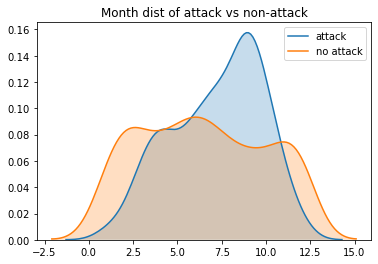

In [77]:
attack = df_model['attack_binary'] == 1
noattack = df_model['attack_binary'] == 0


sns.kdeplot(data = df_model.loc[attack, 'month'], shade = True, label = 'attack')
sns.kdeplot(data = df_model.loc[noattack, 'month'], shade = True, label = 'no attack')
plt.title("Month dist of attack vs non-attack")
plt.legend()
plt.show()

# Hour Logistic Regression

As you can see, the hourly data did yield a high ROC AUC score and seems to be a strong indicator of shark attack occurence. Unfortunately my probability predictions seem a bit innacurate due to the fact that I used sin/cos encoding and we got an assumed two peaks, which is not accurate. This is because sin/cos enforces periodcity.  Moving onto the next logistic regression, I decided to bucketize the hours to help with this accuracy.

              precision    recall  f1-score   support

           0       0.79      0.66      0.72       144
           1       0.70      0.82      0.76       143

    accuracy                           0.74       287
   macro avg       0.74      0.74      0.74       287
weighted avg       0.75      0.74      0.74       287

ROC_AUC: 0.7642288267288266
Intercept is  [-1.01823709]
Coefficient is  [[-0.84152096 -2.18175898]]


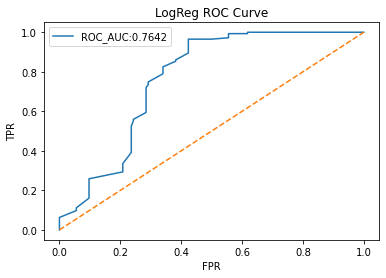

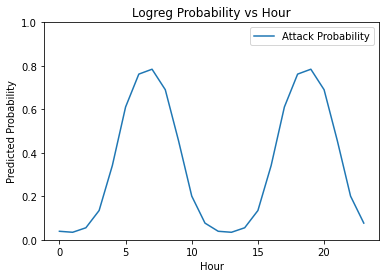

In [78]:
df_model['hour_sin'] = np.sin(2*np.pi*df_model['time_of_attack_hour']/24)
df_model['hour_cos'] = np.cos(2*np.pi*df_model['time_of_attack_hour']/24)

X = df_model[['hour_sin', 'hour_cos']]
y = df_model['attack_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_prob))

print("Intercept is ", model.intercept_)
print("Coefficient is ", model.coef_)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label = f"ROC_AUC:{roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], linestyle = "--")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogReg ROC Curve')
plt.legend()
plt.show()

range_ = np.arange(0,24)
hour_sin = np.sin(2*np.pi*range_/12)
hour_cos = np.cos(2*np.pi*range_/12)
xp = np.c_[hour_sin, hour_cos]
prob = model.predict_proba(xp)[:,1]
plt.xlabel('Hour')
plt.ylabel('Predicted Probability')
plt.title('Logreg Probability vs Hour')
plt.ylim(0,1)
plt.plot(range_, prob, label = 'Attack Probability')
plt.legend()
plt.show()

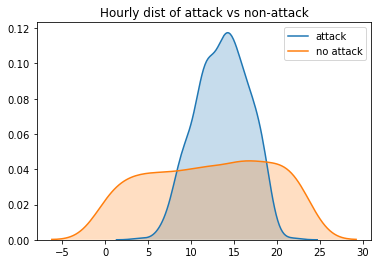

In [79]:
attack = df_model['attack_binary'] == 1
noattack = df_model['attack_binary'] == 0


sns.kdeplot(data = df_model.loc[attack, 'time_of_attack_hour'], shade = True, label = 'attack')
sns.kdeplot(data = df_model.loc[noattack, 'time_of_attack_hour'], shade = True, label = 'no attack')
plt.title("Hourly dist of attack vs non-attack")
plt.legend()
plt.show()

# Hourly Bucket Logistic Regression

For this model, I bucketed the hours into 5 different categories: Night, morning, mid-day, afternoon, evening, night. As you can see, I split the day categories in to 4 groups evenly, and then had the night as a large bucket by itself that is 2x the size as the other buckets. The reasoning behind this is because there are very few beachgoers in the evening, so it doesnt make sense for it to have the same weight as the other categories. 

              precision    recall  f1-score   support

           0       0.76      0.67      0.71       144
           1       0.70      0.79      0.74       143

    accuracy                           0.73       287
   macro avg       0.73      0.73      0.73       287
weighted avg       0.73      0.73      0.73       287

ROC_AUC: 0.7839452214452214
Intercept is  [0.81176111]
Coefficient is  [[-0.83249805 -0.13858556 -1.56351051 -3.98673338]]


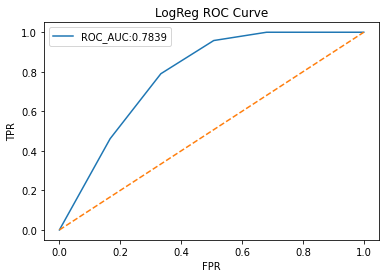

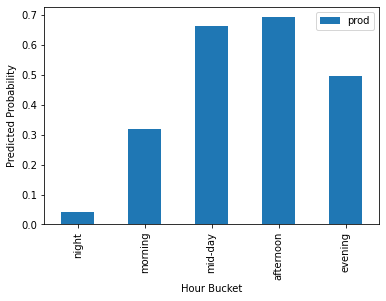

In [80]:
def new_hour_bucket(hr):
    if 5<= hr <9:
        return 'morning'
    if 9<= hr <13:
        return 'mid-day'
    if 13<= hr <17:
        return 'afternoon'
    if 17<= hr <21:
        return 'evening'
    else:
        return 'night'

df_model['hour_bucket'] = df_model['time_of_attack_hour'].apply(new_hour_bucket)


X = pd.get_dummies(df_model[['hour_bucket']], drop_first=True)
y = df_model['attack_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_prob))

print("Intercept is ", model.intercept_)
print("Coefficient is ", model.coef_)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label = f"ROC_AUC:{roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], linestyle = "--")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogReg ROC Curve')
plt.legend()
plt.show()


prob = model.predict_proba(X)[:,1]
df_plot = pd.DataFrame({'bucket': df_model['hour_bucket'], 'prod':prob})
df_plot.groupby('bucket').mean().reindex(['night', 'morning', 'mid-day', 'afternoon', 'evening']).plot(kind = 'bar')
plt.xlabel('Hour Bucket')
plt.ylabel('Predicted Probability')
plt.show()



# Lunar Phase Logistic Regression

Since I had some success bucketting the hourly data, I am going to try and do the same with the lunar illumination data, and used my already bucketted version of this: the Lunar Phases (First Quarter, Full, Last Quarter, New).

As you can see below, the results were quite insignificant. Although we saw a slight skew toward the New Moon in our EDA, you can see below that the Logistic Regression did not confirm this difference to be significant.

              precision    recall  f1-score   support

           0       0.47      0.72      0.57       144
           1       0.41      0.20      0.27       143

    accuracy                           0.46       287
   macro avg       0.44      0.46      0.42       287
weighted avg       0.44      0.46      0.42       287

ROC_AUC: 0.4487665112665113
Intercept is  [0.12147801]
Coefficient is  [[-0.1751672  -0.16682189 -0.13025515]]


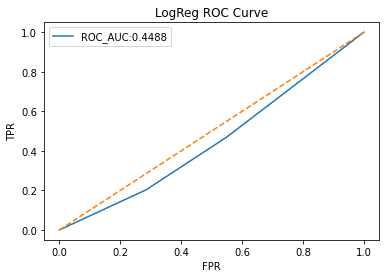

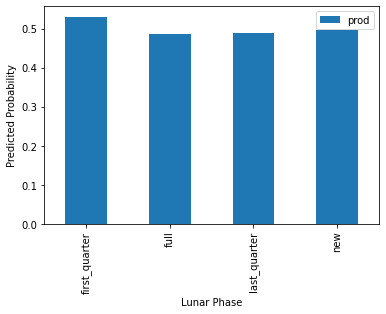

In [81]:


X = pd.get_dummies(df_model[['lunar_phase']], drop_first=True)
y = df_model['attack_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_prob))

print("Intercept is ", model.intercept_)
print("Coefficient is ", model.coef_)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label = f"ROC_AUC:{roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], linestyle = "--")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogReg ROC Curve')
plt.legend()
plt.show()


prob = model.predict_proba(X)[:,1]
df_plot = pd.DataFrame({'Lunar Phase': df_model['lunar_phase'], 'prod':prob})
df_plot.groupby('Lunar Phase').mean().reindex(['first_quarter', 'full', 'last_quarter', 'new']).plot(kind = 'bar')
plt.xlabel('Lunar Phase')
plt.ylabel('Predicted Probability')
plt.show()


# Month and Hourly Bucket Logistic Regression

For this final logistic regression model, I wanted to combine Month and the hourly bucket data to see if we could get a significant result. Because those two features alone, showed some promising results, I decided to combine them to see if I could create an enhanced model. The ROC_AUC score was quite significant for this value, so I think this model did yield a significant result, showing both together are strong predictors of an attack occurence.

              precision    recall  f1-score   support

           0       0.88      0.61      0.72       144
           1       0.70      0.92      0.79       143

    accuracy                           0.76       287
   macro avg       0.79      0.76      0.76       287
weighted avg       0.79      0.76      0.76       287

ROC_AUC: 0.7988053613053613
Intercept is  [0.25151363]
Coefficient is  [[ 0.08329165 -0.86017853 -0.14383528 -1.60011243 -4.00051617]]


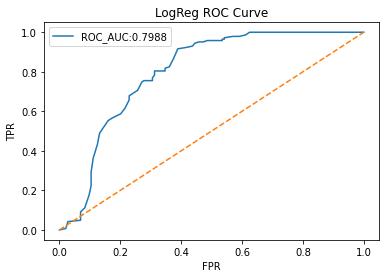

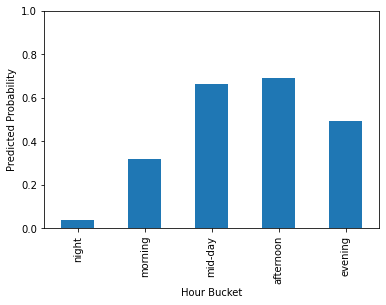

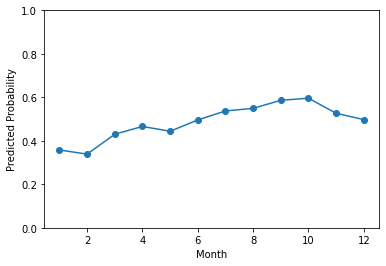

In [82]:
X = pd.get_dummies(df_model[['month', 'hour_bucket']], drop_first=True)
y = df_model['attack_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_prob))

print("Intercept is ", model.intercept_)
print("Coefficient is ", model.coef_)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label = f"ROC_AUC:{roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], linestyle = "--")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogReg ROC Curve')
plt.legend()
plt.show()


df_model['prob'] =model.predict_proba(X)[:,1]

bucket_ = df_model.groupby('hour_bucket')['prob'].mean()
plt.figure()
bucket_.reindex(['night', 'morning', 'mid-day', 'afternoon', 'evening']).plot(kind = 'bar')
plt.ylim(0,1)
plt.xlabel('Hour Bucket')
plt.ylabel('Predicted Probability')
plt.show()



month_ = df_model.groupby('month')['prob'].mean()
plt.figure
month_.plot(marker = 'o')
plt.ylim(0,1)
plt.xlabel('Month')
plt.ylabel('Predicted Probability')
plt.show()


# Part 4: Modeling Pressure and Temperature on Attack Occurence

I got some interesting results with the Temporal data, but now I would like to take the analysis a step further and bring in some weather features, such as pressure and temperature. Below I am pulling in data from meteostat and merging it in with my original dataframe df_clean

# Data Import and Cleansing

In [36]:
# !pip uninstall -y meteostat
!pip install -q "meteostat==1.6.1"
!pip install "pandas>=1.2,<1.4"


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [37]:
from meteostat import Point, Hourly, Stations

After importing all data and libraries needed, I am printing all the stations below to see which ones I want to include in my dataset. Ideally I would like bring in all counties that are in df_clean, but because of time and length considerations, I will have to save that for future analysis. 

Out of the three counties I see below, I believe my best options are Volusia, Brevard and Duval. All three represent three distinct Atlantic Coast regions in Florida (South, Central, and North Coast), and have a large number of datapoints for me to analyze. 

In [38]:
print(df_clean['county'].value_counts(dropna = False))

volusia county         322
brevard county         104
palm beach county       66
st. johns county        31
st. lucie county        31
duval county            29
martin county           27
indian river county     19
miami-dade county       14
broward county          13
flagler county           6
nassau county            6
dade county              2
miami-dade               1
Name: county, dtype: int64


Here I am printing all the stations that are nearby the county seat of all these counties.

In [39]:
volusia = Stations().nearby(29.0283, -81.0755)
brevard = Stations().nearby(28.2639, -80.7214)
duval = Stations().nearby(30.3500, -81.6035)

volusia = volusia.inventory('hourly')
brevard = brevard.inventory('hourly')
duval = duval.inventory('hourly')

vstations = volusia.fetch(10)
bstations = brevard.fetch(10)
dstations = duval.fetch(10)

print(vstations[[ 'name', 'latitude', 'longitude', 'region']])
print(bstations[['name', 'latitude', 'longitude',  'region']])
print(dstations[[ 'name', 'latitude', 'longitude', 'region']])

                                                    name  latitude  longitude  \
id                                                                              
KEVB0                        New Smyrna Beach / Isleboro   29.0557   -80.9489   
74787         Daytona Beach / Mansfield Mobile Home Park   29.1799   -81.0581   
KDED0               Deland / Orangewood Mobile Home Park   29.0670   -81.2837   
KOMN0         Ormond Beach / Bear Creek Mobile Home Park   29.3006   -81.1136   
KSFB0                         Sanford / Orlando / Midway   28.7767   -81.2355   
KXFL0             Palm Coast / Palm Terrace Mobile Manor   29.4674   -81.2063   
KTTS0                              Cape Kennedy / Wilson   28.6149   -80.6944   
KORL0                              Orlando / Azalea Park   28.5455   -81.3329   
KTIX0  Titusville / Manatee Hammock Park Mobile Home ...   28.5148   -80.7992   
72205                                    Orlando Airport   28.4167   -81.0000   

      region  
id          

I have chosen the following stations based on their proximity to beaches (where shark attacks happen)

Volusia: KEVB0                    New Smyrna Beach / Isleboro   29.0557   -80.9489   
Brevard: 74795                     Cocoa / Patrick Air Force Base   28.2333   -80.6000  
Duval: KNRB0                                            Mayport   30.3914   -81.4245   


In [40]:
for st_id in ['KEVB0', '74795', 'KNRB0']:
    data = Hourly(st_id, start = pd.Timestamp("2003-04-08"), end = pd.Timestamp("2003-04-08")).fetch()
    print(st_id)
    print(data.columns)
    print(data[['temp', 'pres', ]].head())

KEVB0
Index(['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'coco'],
      dtype='object')
Empty DataFrame
Columns: [temp, pres]
Index: []
74795
Index(['date', 'hour', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd',
       'wpgt', 'pres', 'tsun', 'coco'],
      dtype='object')
Empty DataFrame
Columns: [temp, pres]
Index: []
KNRB0
Index(['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'coco'],
      dtype='object')
            temp    pres
time                    
2003-04-08  22.8  1017.5


Now I am going through and creating a new dataframe that will hold all the hourly meteorological data I want, and then merging it with my shark attack dataset (df_clean).

I should also note here, that I am only taking data from 2001 onward, because the weather data prior to this time can be a bit spotty.

Additionally I am creating 8 new features from the data:

t_detla12- The temperature change from 12 hours past to the time of occurence
t_delta24- The temperature change from 24 hours past to the time of occurence
p_delta12- The pressure change from 12 hours past to the time of occurence
p_delta24- The pressure change from 24 hours past to the time of occurence

t_slope12- The slope of the temperature change from 12 hours past to the time of occurence
t_slope24- The slope of the temperature change from 24 hours past to the time of occurence
p_slope12- The slope of the pressure change from 12 hours past to the time of occurence
p_slope24- The slope of the pressure change from 24 hours past to the time of occurence

I added these features because I was interested to see if not only the pressure and temperature in itself were strong indicators of an attack occurence, but I also wanted to understand if the change in these features could be of significance too. 

In [41]:
county_stat = {'volusia county': 'KEVB0', 'brevard county': '74795', 'duval county': 'KNRB0'}

df_a = df_clean[df_clean['county'].str.contains("Volusia|Brevard|Duval", case = False)].copy()

df_meteo = []

for county, st_id in county_stat.items():
    subset = df_a[df_a['county'].str.contains(county, case = False)].copy()
    subset = subset[subset['date_at_location']  >= pd.Timestamp("2000-01-01") ]
    
    if subset.empty:
        continue
    
    start = subset['date_at_location'].min()
    end = subset['date_at_location'].max()
    
    meteo = Hourly(st_id, start, end).fetch()
    meteo = meteo.sort_index()
    
    meteo['t_delta12'] = meteo['temp'].diff(12)
    meteo['t_delta24'] = meteo['temp'].diff(24)
    meteo['p_delta12'] = meteo['pres'].diff(24)
    meteo['p_delta24'] = meteo['pres'].diff(24)
    
    meteo['t_slope12'] = (meteo['temp'] - meteo['temp'].shift(12))/12
    meteo['t_slope24'] = (meteo['temp'] - meteo['temp'].shift(24))/24
    meteo['p_slope12'] = (meteo['pres'] - meteo['pres'].shift(12))/12
    meteo['p_slope24'] = (meteo['pres'] - meteo['pres'].shift(24))/24
    
    subset['attack_hour'] = subset['date_at_location'].dt.floor('H')
    meteo_subset = pd.merge(subset, meteo, left_on = 'attack_hour', right_index = True, how = 'left')
    meteo_subset['county_match'] = county
    df_meteo.append(meteo_subset)

df_meteo = pd.concat(df_meteo, ignore_index = True)

print(df_meteo[['county_match', 'date_at_location', 'temp', 'pres', 't_delta12',
               't_delta24', 'p_delta12', 'p_delta24']].head(200))

       county_match date_at_location  temp    pres  t_delta12  t_delta24  \
0    volusia county       2000-06-02   NaN     NaN        NaN        NaN   
1    volusia county       2000-06-19   NaN     NaN        NaN        NaN   
2    volusia county       2000-07-02   NaN     NaN        NaN        NaN   
3    volusia county       2000-07-02   NaN     NaN        NaN        NaN   
4    volusia county       2000-07-04   NaN     NaN        NaN        NaN   
..              ...              ...   ...     ...        ...        ...   
195  volusia county       2021-08-14  26.0  1020.0       -3.0       -2.0   
196  volusia county       2021-09-05  26.0  1014.0        0.0        0.0   
197  volusia county       2021-09-08  27.0  1015.0        1.0        0.0   
198  volusia county       2021-09-09  24.0  1013.0       -3.0       -3.0   
199  volusia county       2021-09-11  26.0  1016.0        1.0        0.0   

     p_delta12  p_delta24  
0          NaN        NaN  
1          NaN        NaN  
2  

Below I am inspecting my final dataframe to see what I have. It looks as though I have a lot of nan values for air temp and pressure. To combat this, I will use bfill and ffill, which will help me backfill (to the nearest hour) any missing weather data. 

In [42]:
print(len(df_meteo))
print(df_meteo.isna().sum())
#print((df_meteo.isna().mean()*100).round(2))


284
attack_classification         0
outcome                       0
county                        0
date_at_location              0
Year                          0
time_of_attack                2
victim_activity               0
sunlight_conditions           0
gen_weather                   0
air_temp                    134
water_temp                   99
closest_phase                 0
waxing_waning                 0
common_name                   0
provocative_acts              0
activity_addenda              0
outcome_binary                0
outcome_ternary               0
time_of_attack_hour          34
time_unknown_flag             0
time_bucket                   0
month                         0
season                        0
hour_sin                     34
hour_cos                     34
lunar_illumination_phase      0
lunar_illumination_frac       0
lunar_illumination_pct        0
lunar_phase                   0
attack_hour                   0
temp                        188
dwpt

In [43]:
df_meteo['p_nan'] = df_meteo['pres'].isna().astype(int)
df_meteo['t_nan'] = df_meteo['temp'].isna().astype(int)

df_meteo2 = df_meteo.groupby('county_match').apply(lambda g: g.ffill().bfill()).reset_index(drop = True)
#print(df_meteo2.isna().sum())

df_meteo2['p_nan'] = df_meteo['p_nan'].values
df_meteo2['t_nan'] = df_meteo['t_nan'].values

In [44]:
print(df_meteo2[['temp', 'pres', 't_delta12', 'p_delta12']].describe())
print(df_meteo2['county_match'].value_counts())

             temp        pres   t_delta12   p_delta12
count  284.000000   284.00000  284.000000  284.000000
mean    25.816549  1015.94507    2.089437   -1.398239
std      2.823145     1.91828    4.898622    1.735280
min     12.000000  1005.00000  -11.000000   -8.200000
25%     24.000000  1016.00000   -1.000000   -2.000000
50%     26.000000  1016.00000    2.000000   -2.000000
75%     29.000000  1016.00000    6.000000   -1.100000
max     29.400000  1022.00000   13.000000   13.200000
volusia county    221
brevard county     45
duval county       18
Name: county_match, dtype: int64


# EDA on Pressure and Temperature

**Weather Visualizations**

The below visualizations are some significant features that were found to be of note when inspecting the weather data. Data was pulled in from meteostat, which is a python library that contains weather data pulled from NOAA weather stations. With this, a new data byproduct was created, enriching the original shark attack data with meteorological features. A further note regarding this byproduct is that non-attack occurrences were created for comparison to the attack occurrences, but this will be discussed later in this paper.

There are some  basic box-and-whisker plots that show the distribution of attacks across three different features: temperature, change in pressure, and rate of change (or slope) of pressure. Other features were visualized, but these were the most pertinent to modeling. As one can see by the below visualizations, there is a slight skew toward higher temperature on the attack values vs non-attack values. Additionally, the change in pressure and slope of pressure change give an even slighter skew higher. Moving to the modeling phase, these observations will be tested for their statistical significance. 


As you can see, just looking at the pressure and time data alone, to identify shark attack occurence, doesnt do much, so I am going to do something similar to what I did before for my Temporal models and create a synthetic negative set that will represent a non-attack occurence. 

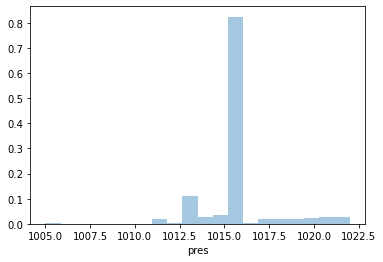

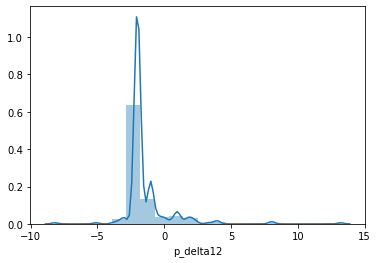

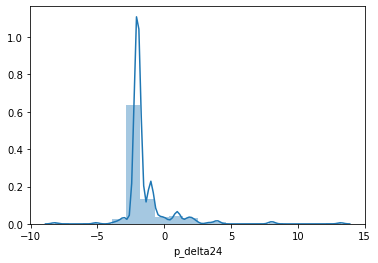

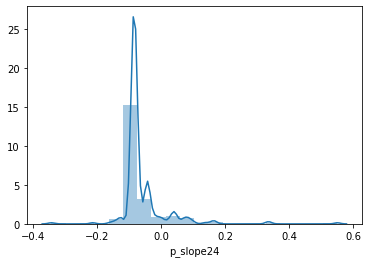

In [45]:

# sns.distplot(df_meteo2['temp'], bins = 20, kde = True)
# plt.show()

sns.distplot(df_meteo2['pres'], bins = 20, kde = True)
plt.show()

sns.distplot(df_meteo2['p_delta12'], bins = 20, kde = True)
plt.show()

sns.distplot(df_meteo2['p_delta24'], bins = 20, kde = True)
plt.show()

sns.distplot(df_meteo2['p_slope24'], bins = 20, kde = True)
plt.show()

# sns.distplot(df_meteo2['t_delta12'], bins = 20, kde = True)
# plt.show()

**Creating Synthetic Negatives- Weighting Beachgoer Seasonality**

To create synthetic negatives the same length as the existing dataset, the simplest approach is to use a random choice function pick non-attack occurrences that are not within the existing dataset. While this is easy to implement, there are some drawbacks to this. For this particular problem, the drawback is that shark attacks only occur when people are present. Furthermore, there are more or less people present at beaches in a) certain times of the year (seasonality) and b) in certain times of the day. If one was to randomly grab days using a random choice function, the randomization would not account for this seasonality and time of day where beachgoers are present. 

So, how does one go about normalizing the random choice function to account for beachgoer seasonality? In this instance, data was taken from a publicly accessible dataset created by the University of West Florida in the form of monthly flight inflow data into Florida Coastal airports. Using this data, monthly weights were applied to the randomization to account for the seasonality of beachgoers. 


It should be noted, that this weighting is not a perfect representation of when individuals go to the beach, but it does provide a directionally correct indication of beachgoer seasonality. Additionally, although this data is captured on a monthly basis, this particular project did not account for time-of-day (hourly) beach going patterns. This is a note that was created to be implemented in future iterations of this modeling to increase efficacy. Finally, in the case of temporal models, seasonality was not able to be implemented as the synthetic negatives were randomized on an hourly basis to match the dataset. The weather data was specifically where seasonally-adjusted synthetic negatives were implemented. The limitation of the temporal models’ synthetic negatives is noted and will fixed for future iterations. 



In [47]:
df_2['month'] = pd.to_datetime(df_2['Day of Year']).dt.month

weight_m = df_2.groupby('month')['Airline Passengers'].sum().reindex(range(1,13), fill_value =0)
weight_norm = weight_m/weight_m.sum()

print(weight_norm, weight_m)


month
1     0.060234
2     0.062019
3     0.083680
4     0.086371
5     0.091415
6     0.103811
7     0.104478
8     0.094826
9     0.079498
10    0.087067
11    0.075593
12    0.071008
Name: Airline Passengers, dtype: float64 month
1     3909262
2     4025125
3     5430959
4     5605609
5     5932964
6     6737491
7     6780733
8     6154342
9     5159502
10    5650741
11    4906060
12    4608478
Name: Airline Passengers, dtype: int64


After creating my weights above, I now created my synthetic negatives based on those weightings. This allows me to skew the negative occurences (my no-attack values) toward the summer months. Here, after creating these negative occurences, I am joining them to my positive data set. I should note, also, that I am filling the negative occurences with randome weather values from the day I am choosing as well, so that we can compare like features in the positive set. 

In [65]:
m= weight_norm.index
w = weight_norm.values

cols = ['date_at_location', 'county_match', 'temp', 'pres', 't_delta12', 't_delta24', 'p_delta12', 'p_delta24',
        't_slope12', 't_slope24', 'p_slope12', 'p_slope24', 't_nan', 'p_nan']

#df_meteo2 = df_meteo2.copy()
df_meteo2['month'] = pd.to_datetime(df_meteo2['date_at_location']).dt.month

df_pos2 = df_meteo2.copy()
df_pos2['attack_binary'] = 1

neg_m = np.random.choice(m, size = len(df_meteo2), p = w)

neg_row = []
for mm in neg_m:
    p = df_meteo2[df_meteo2['month'] == mm]
    if p.empty:
        p = df_meteo2
    r = p.sample(1, replace = True).iloc[0]
    neg_row.append(r[cols + ['month']])
    
df_neg2 = pd.DataFrame(neg_row).reset_index(drop = True)
df_neg2['attack_binary'] = 0

df_metmodel = pd.concat([df_pos2, df_neg2], ignore_index = True)
print(df_metmodel['attack_binary'].value_counts())
print(df_metmodel.head())

1    284
0    284
Name: attack_binary, dtype: int64
  attack_classification    outcome          county date_at_location    Year  \
0     unprovoked attack  non-fatal  volusia county       2000-06-02  2000.0   
1     unprovoked attack  non-fatal  volusia county       2000-06-19  2000.0   
2     unprovoked attack  non-fatal  volusia county       2000-07-02  2000.0   
3     unprovoked attack  non-fatal  volusia county       2000-07-02  2000.0   
4     unprovoked attack  non-fatal  volusia county       2000-07-04  2000.0   

  time_of_attack                 victim_activity sunlight_conditions  \
0          14:55  body surfing, planing on waves            daylight   
1          08:30                          wading            daylight   
2          17:02        standing still on bottom            daylight   
3          14:50        standing still on bottom            daylight   
4          18:00                          wading            daylight   

                       gen_weather  air_

Here I am starting my EDA with the newly added synthetic negatives.

As you can see below, it seems a though there is a slight skew toward higher temperatures for attack occurences, as well as a slight skew toward changes in pressure over a 24 hour span, as well as the slope in the change of pressure over the same 24 hour span. 

This is an interesting finding to me, and I wonder if we can actually prove that these are strong indicators of an attack vs non-attack in our models. So I will take note of these features for now and include them in my modeling. 

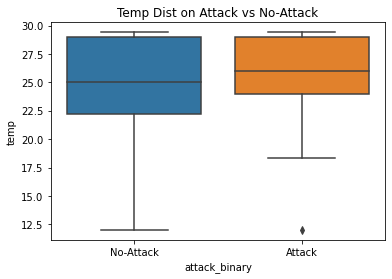

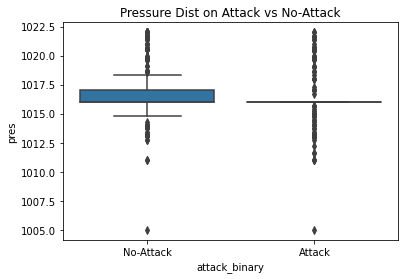

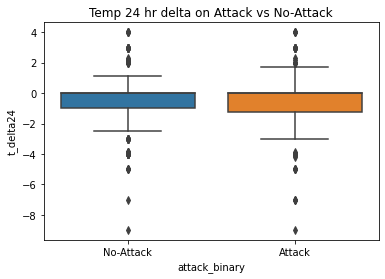

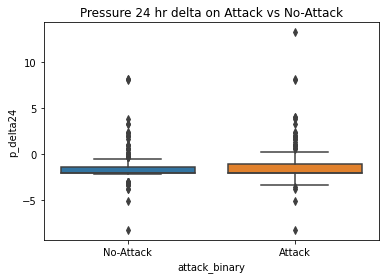

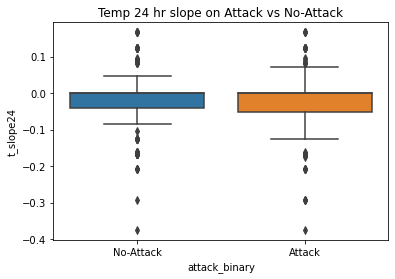

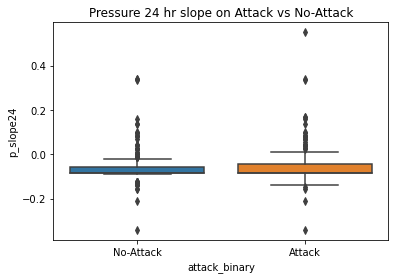

In [67]:
plt.figure()
sns.boxplot(x = 'attack_binary', y = 'temp', data = df_metmodel)
plt.xticks([0,1], ['No-Attack', 'Attack'])
plt.title('Temp Dist on Attack vs No-Attack')
plt.show()

plt.figure()
sns.boxplot(x = 'attack_binary', y = 'pres', data = df_metmodel)
plt.xticks([0,1], ['No-Attack', 'Attack'])
plt.title('Pressure Dist on Attack vs No-Attack')
plt.show()

plt.figure()
sns.boxplot(x = 'attack_binary', y = 't_delta24', data = df_metmodel)
plt.xticks([0,1], ['No-Attack', 'Attack'])
plt.title('Temp 24 hr delta on Attack vs No-Attack')
plt.show()

plt.figure()
sns.boxplot(x = 'attack_binary', y = 'p_delta24', data = df_metmodel)
plt.xticks([0,1], ['No-Attack', 'Attack'])
plt.title('Pressure 24 hr delta on Attack vs No-Attack')
plt.show()

plt.figure()
sns.boxplot(x = 'attack_binary', y = 't_slope24', data = df_metmodel)
plt.xticks([0,1], ['No-Attack', 'Attack'])
plt.title('Temp 24 hr slope on Attack vs No-Attack')
plt.show()

plt.figure()
sns.boxplot(x = 'attack_binary', y = 'p_slope24', data = df_metmodel)
plt.xticks([0,1], ['No-Attack', 'Attack'])
plt.title('Pressure 24 hr slope on Attack vs No-Attack')
plt.show()

Again, another set of visualizations, this time limited to the three features I have honed in on: temperature, change in pressure over the past 24 hours, as well as the slope of this change. I think we see some variability here between these two features that we can investigate in our models

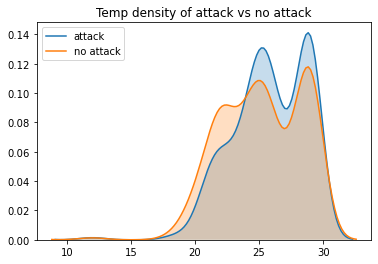

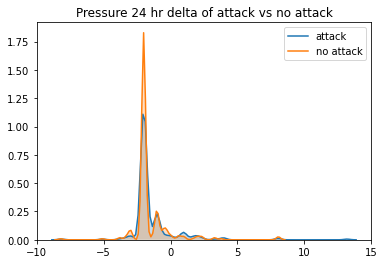

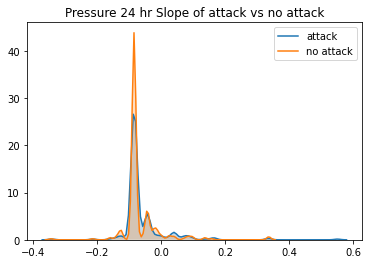

In [68]:
plt.figure()
sns.kdeplot(df_metmodel.loc[df_metmodel['attack_binary']==1, 'temp'], label = 'attack', shade = True)
sns.kdeplot(df_metmodel.loc[df_metmodel['attack_binary']==0, 'temp'], label = 'no attack', shade = True)
plt.title('Temp density of attack vs no attack')
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(df_metmodel.loc[df_metmodel['attack_binary']==1, 'p_delta24'], label = 'attack', shade = True)
sns.kdeplot(df_metmodel.loc[df_metmodel['attack_binary']==0, 'p_delta24'], label = 'no attack', shade = True)
plt.title('Pressure 24 hr delta of attack vs no attack')
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(df_metmodel.loc[df_metmodel['attack_binary']==1, 'p_slope24'], label = 'attack', shade = True)
sns.kdeplot(df_metmodel.loc[df_metmodel['attack_binary']==0, 'p_slope24'], label = 'no attack', shade = True)
plt.title('Pressure 24 hr Slope of attack vs no attack')
plt.legend()
plt.show()

# Modeling Temperature, 24 Hour Pressure Change, and 24 Hour Pressure Slope

As you can see, my temperature turned out to be a poor indicator. My model really only prediced the outcome based on this feature little more than a coin flip could have. Lets move on to pressure change

In [69]:
#X_arrary = ['temp', 'p_delta24', 'p_slope24']

X = df_metmodel[['temp']]
y = df_metmodel['attack_binary']


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(model.coef_)


              precision    recall  f1-score   support

           0       0.54      0.56      0.55        86
           1       0.54      0.52      0.53        85

    accuracy                           0.54       171
   macro avg       0.54      0.54      0.54       171
weighted avg       0.54      0.54      0.54       171

[[48 38]
 [41 44]]
[[0.07423246]]


Pressure change, unfortunately turned out to be a poor indicator as well, again only being slightly better than an coin flip

In [70]:


X = df_metmodel[['p_delta24']]
y = df_metmodel['attack_binary']


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(model.coef_)

              precision    recall  f1-score   support

           0       0.52      0.77      0.62        86
           1       0.55      0.28      0.37        85

    accuracy                           0.53       171
   macro avg       0.53      0.52      0.50       171
weighted avg       0.53      0.53      0.50       171

[[66 20]
 [61 24]]
[[0.06484879]]


As one would expect, the slope (similar to pressure change), preformed poorly as well. 

In [71]:

X = df_metmodel[['p_slope24']]
y = df_metmodel['attack_binary']


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(model.coef_)

              precision    recall  f1-score   support

           0       0.52      0.77      0.62        86
           1       0.55      0.28      0.37        85

    accuracy                           0.53       171
   macro avg       0.53      0.52      0.50       171
weighted avg       0.53      0.53      0.50       171

[[66 20]
 [61 24]]
[[0.51984869]]


Finally, lets try combining all three features to see if we can create a stronger model. Unfortunately again, it looks like we are slightly better than a coin flip on this model, so I think we can conclude these features are not strong indicators of shark attack occurence. 

              precision    recall  f1-score   support

           0       0.55      0.63      0.59        86
           1       0.56      0.48      0.52        85

    accuracy                           0.56       171
   macro avg       0.56      0.56      0.55       171
weighted avg       0.56      0.56      0.55       171

[[54 32]
 [44 41]]
[[0.08335977 0.09148068 0.0038117 ]]
0.5606703146374828


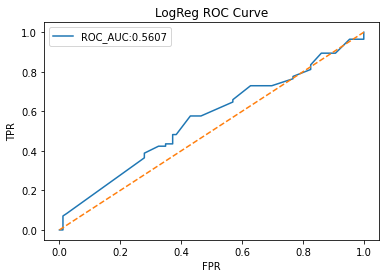

In [72]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline

X = df_metmodel[['temp', 'p_delta24', 'p_slope24']]
y = df_metmodel['attack_binary']


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify = y, random_state = 42)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
#model = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1000, class_weight = 'balanced'))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(model.coef_)
print(roc_auc_score(y_test, y_prob))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label = f"ROC_AUC:{roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], linestyle = "--")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogReg ROC Curve')
plt.legend()
plt.show()

# Part 5:  Results, Conclusions, Notes for Further Investigation, and Potential Applications of Findings 

**Modeling Results**

In this project, 10 separate Logistic regression models were created. They are as follows:

1.	Shark Attack Occurrence ~ Lunar Illumination, 
2.	Shark Attack Occurrence ~ Month of Attack, 
3.	Shark Attack Occurrence ~ Hour of Attack, 
4.	Shark Attack Occurrence ~ Hourly Bucket (Time of Day), 
5.	Shark Attack Occurrence ~ Lunar Phase, 
6.	Shark Attack Occurrence ~ Month of Attack + Hourly Bucket (Time of Day), 
7.	Shark Attack Occurrence ~ Temperature,
8.	Shark Attack Occurrence ~ 24 Hour Pressure Change,
9.	Shark Attack Occurrence ~ 24 Hour Pressure Rate of Change,
10.	Shark Attack Occurrence ~ Temp + 24 Hour Pressure Change + 24 Hour Pressure Rate of Change


**Model Performance Summary and Comparison**

### Model Performance Summary

| Model                                                        | Encoding                                | ROC-AUC | Notes                                                           |
|--------------------------------------------------------------|-----------------------------------------|---------|-----------------------------------------------------------------|
| **Shark Attack Occurrence ~ Lunar Illumination**             | Continuous                              | ~0.50   | Weak; nearly random performance.                                |
| **Shark Attack Occurrence ~ Month of Attack**                | Cyclical (sin/cos)                      | ~0.69   | Not a strong predictor; small seasonal effect visible.          |
| **Shark Attack Occurrence ~ Hour of Attack**                 | Cyclical (sin/cos)                      | ~0.76   | Moderate strength; improves over month alone.                   |
| **Shark Attack Occurrence ~ Hourly Bucket (Time of Day)**    | Categorical                             | ~0.78   | Strongest single predictor; captures diurnal patterns well.     |
| **Shark Attack Occurrence ~ Lunar Phase**                    | Categorical (New, Full, etc.)           | ~0.45   | Weak; nearly random performance.                                |
| **Shark Attack Occurrence ~ Month of Attack + Hourly Bucket**| One-hot month + Categorical             | ~0.80   | Best performing combined model; strong diurnal + seasonal signal.|
| **Shark Attack Occurrence ~ Temperature**                    | Continuous (°C)                         | ~0.53   | Weak; nearly random performance.                                |
| **Shark Attack Occurrence ~ 24 Hour Pressure Change**        | Continuous (Δ pressure, hPa)            | ~0.54   | Weak; nearly random performance.                                |
| **Shark Attack Occurrence ~ 24 Hour Pressure Rate of Change**| Continuous (slope, hPa/hr)              | ~0.54   | Weak; nearly random performance.                                |
| **Shark Attack Occurrence ~ Temp + Pressure Features**       | Continuous (3 features)                 | ~0.56   | Adding multiple meteorological features doesn’t improve model.  |

For the sake of brevity, only two of the most significant results will be listed in this section from both the Temporal and Weather category, but all results are in the above notebook.

For the temporal data “Shark Attack Occurrence ~ Month of Attack + Hourly Bucket (Time of Day)” yielded the most significant results. As you can see by the results, combining these two features yielded a combined ROC AUC score of ~80%. This is a significant outcome, and means this combo model has a strong chance of predicting shark attack occurrence vs non-occurrence. 

In the predicted probability charts for the monthly and hourly data in this model, one can see that the distribution of attack probability is similar to the real-world distribution of shark attacks that was seen in the EDA visualizations earlier. This is a robust result, because it shows the model is predicting in a similar fashion to real world outcomes. 

Additionally, providing the hourly and monthly distribution of attack vs non-attack below to visually see how the model parsed through positive and negative events in the test and train data: 


For the Weather data, “Shark Attack Occurrence ~ Temp + 24 Hour Pressure Change + 24 Hour Pressure Rate of Change” yielded the most significant result. Unfortunately, this model was little better than a coin flip in predicting shark attack occurrences from these three variables stacked, with an ROC AUC score barely over 50%



**Discussion of Results**

Looking at the results of the modeling done on this dataset, it is easy for one to tell that the temporal indicators provided the results of the highest value. Looking at the overall ROC AUC score of ~80% on the Hourly and Month day combination, this model is provides high efficacy and will accurately predict the occurrence of an attack 76% of the time (accuracy score) when given date-time info. In terms of which model should be iterated upon “Shark Attack Occurrence ~ Month of Attack + Hour of Attack” is the most promising. 

Other temporal data features looked promising as well, but may need further refinement. Lunar phases and lunar illumination, which were previously hypothesized to be a potential indicator, but yielded poor results when modelled. This information in itself is useful though in that it tells us that Lunar Phases may have no correlation whatsoever with shark attack occurrences. In this respect, Lunar temporal data requires further investigation. 

In regards to the meteorological features- Those that were chosen for modeling (Temperature, 24 Hour Pressure Delta, and 24 Hour Pressure Rate of Change) were extremely poor indicators of shark attack occurrence. There may be further credence to the use of these features as indicators, if modeling is enhanced, but for the time being they lack a significance in the current iteration. 

**Limitations of Current Model**

One notable limitation for the current model is that synthetic negative events for temporal data were completely randomly generated and in future iterations, implementing seasonality and time-of-day into the random choice function would increase model efficacy Additionally time-of-day generation in both random choice functions for temporal and weather data, if beachgoer hourly data is captured would increase model efficacy

Furthermore, lack of expertise in ichthyology and shark research could have caused disregard for potential in other features that could increase the model efficacy. In future iterations, working with the ISAF researchers and gaining first-hand knowledge in shark behavior could help direct additional features to include.

Finally, bias in the geographical nature of data, being that this subset only included Florida Atlantic coast attacks could have very well skewed the results of certain models. Running a global or continent based model could drown out these regional biases. Additionally splitting the data along these regional lines could yield interesting and different results.

**Future Applications and Model Iterations**

One potential application of a model such as this, when further refined to include additional features to increase overall efficacy, would be the use of a risk indicator of sorts for shark attack occurrence given a specific set of circumstances. Think of a “Smokey the Bear: Wildfire Risk”-type indicator that could provide the generalized risk of a shark attack occurrence. This model could be further refined to add features such as geographical location, tidal and current affects, storm systems in nearby area, species indicators, and so on. With further expert input on the model features to be included, one could more greatly refine to provide individuals with valuable risk information when making decisions about their beach going activities. 



# References



Florida Museum. (n.d.). Beach injuries and fatalities: Comparing risks. Florida Museum of Natural History. Retrieved September 25, 2025, from https://www.floridamuseum.ufl.edu/shark-attacks/odds/compare-risk/beach-injuries-fatalities/

Florida Museum. (n.d.). International Shark Attack File. Florida Museum of Natural History. Retrieved September 25, 2025, from https://www.floridamuseum.ufl.edu/shark-attacks/

University of West Florida, Haas Center. (n.d.). Tourism indicators. University of West Florida. Retrieved September 25, 2025, from https://uwf.edu/centers/haas-center/explore-the-economy/tourism-indicators/

French, L. A., Midway, S. R., Evans, D. H., & Burgess, G. H. (2021). Shark side of the moon: Are shark attacks related to lunar phase? Frontiers in Marine Science, 8, 745221.https://doi.org/10.3389/fmars.2021.745221


OpenAI. (2025). ChatGPT (version GPT-5) [Large language model]. OpenAI. (Used for error trace debugging and function usage examples.)

Google DeepMind. (2025). Gemini [Large language model]. Google DeepMind. (Used for error trace debugging and function usage examples.)

Special acknowledgement: Dr. Gavin Naylor and Joseph Miguez, Florida Program for Shark Research, for providing ISAF data.


In [2]:
#df_clean.to_csv('df_clean_here', index = False)